Inspirováno [https://github.com/xiaxilin/fvm_swes_1d]

In [4]:
from __future__ import absolute_import
import numpy as np
from six.moves import range

class Flux:
    def __init__(self, h = 0.0, q = 0.0):
        self.h = h
        self.q = q
        
class RiemannState:
    def __init__(self, L = 0.0, R = 0.0):
        self.L = L
        self.R = R

In [5]:
import math

#print 'This is a 1D python program for solving 1D shallow water equations with fvm'
#print 'author: xilin xia'
#print 'date: 21/10/2014'

#global arrays
h = [4.]*100+[1.0]*100#[1.0]*100+[0.1]*100
q = [0]*200
zbf = [0]*200
dhdt = [0]*200
dqdt = [0]*200
h_old = [0]*200
q_old = [0]*200
dhdt_old = [0]*200
dqdt_old = [0]*200

#total cell number
N = 200

#parameters
g = 9.81
x_ori = 0.0
dx = 0.05

#time controll
t = 0.0
dt = 0.001
tout = .1


class RiemannState:
    def __init__(self, L = 0.0, R = 0.0):
        self.L = L
        self.R = R

class Flux:
    def __init__(self, h = 0.0, q = 0.0):
        self.h = h
        self.q = q

#hllc riemann solver
def hllc(g, h_face, q_face):
    h_L = h_face.L
    h_R = h_face.R
    q_L = q_face.L
    q_R = q_face.R
    u_L = q_L/h_L
    u_R = q_R/h_R
    h_star_p = (math.sqrt(g*h_L) + math.sqrt(g*h_R)) / 2 + (u_L - u_R) / 4
    u_star = (u_L + u_R) / 2 + math.sqrt(g*h_L) - math.sqrt(g*h_R)
    h_star = (h_star_p*h_star_p) / g

    s_L = min(u_L - math.sqrt(g*h_L), u_star - math.sqrt(g*h_star))
    s_R = max(u_R + math.sqrt(g*h_R), u_star + math.sqrt(g*h_star))
 
    h_flux_L = q_L
    h_flux_R = q_R
    h_flux_star = (s_R*h_flux_L - s_L*h_flux_R + s_L*s_R*(h_R - h_L)) / (s_R - s_L)
    q_flux_L = q_L*u_L + g*h_L*h_L / 2.0
    q_flux_R = q_R*u_R + g*h_R*h_R / 2.0
    q_flux_star = (s_R*q_flux_L - s_L*q_flux_R + s_L*s_R*(q_R - q_L)) / (s_R - s_L)
 
    if 0 <= s_L:
        h_flux = h_flux_L
        q_flux = q_flux_L
    elif  s_L <= 0 and 0 <= s_R:
        h_flux = h_flux_star
        q_flux = q_flux_star
    else:
        h_flux = h_flux_R
        q_flux = q_flux_R

    return Flux(h_flux, q_flux)

#function to calculate dhdt and dqdt
def calcDDt(h,q,dhdt,dqdt,dx):
    N = len(q)
    for i in range(N):
        #west face
        if i == 0:
            h_west = RiemannState(h[i],h[i])
            q_west = RiemannState(q[i],q[i])
        else:
            h_west = RiemannState(h[i-1],h[i])
            q_west = RiemannState(q[i-1],q[i])
        #flux_west = shallow_roe_1D(g, h_west, q_west)    
        flux_west = hllc(g, h_west, q_west) 
        #flux_west = shallow_water_roe(g, h_west, q_west) 
        #flux_west = shallow_water_hll(g, h_west, q_west) 
        

        #east face
        if i == N - 1:
            h_east = RiemannState(h[i],h[i])
            q_east = RiemannState(q[i],q[i])
        else:
            h_east = RiemannState(h[i],h[i+1])
            q_east = RiemannState(q[i],q[i+1])
        #flux_east = shallow_roe_1D(g, h_east, q_east)
        flux_east = hllc(g, h_east, q_east)
        #flux_east = shallow_water_roe(g, h_east, q_east)
        #flux_east = shallow_water_hll(g, h_east, q_east)

        dhdt[i] = - (flux_east.h - flux_west.h)/dx
        dqdt[i] = - (flux_east.q - flux_west.q)/dx


#main function
while t < tout:
    #print(dt, t)
    #first Runge-Kutta
    calcDDt(h,q,dhdt,dqdt,dx)
    h_old = h[:]
    q_old = q[:]
    dhdt_old = dhdt[:]
    dqdt_old = dqdt[:]
    for i in range(N):
        h[i] = h[i] + dhdt[i]*dt
        q[i] = q[i] + dqdt[i]*dt
    #second Runge-Kutta
    calcDDt(h,q,dhdt,dqdt,dx)
    for i in range(N):
        h[i] = h_old[i] + (dhdt[i] + dhdt_old[i])*dt/2.0
        q[i] = q_old[i] + (dqdt[i] + dqdt_old[i])*dt/2.0

    t = t + dt

#output

#f = open('output.txt', 'w')

#for i in range(N):
#    print >> f, '%.6f %.6f %.6f' % (x_ori + i*dx, h[i], q[i])
#    print(x_ori + i*dx, h[i], q[i])
#f.close()

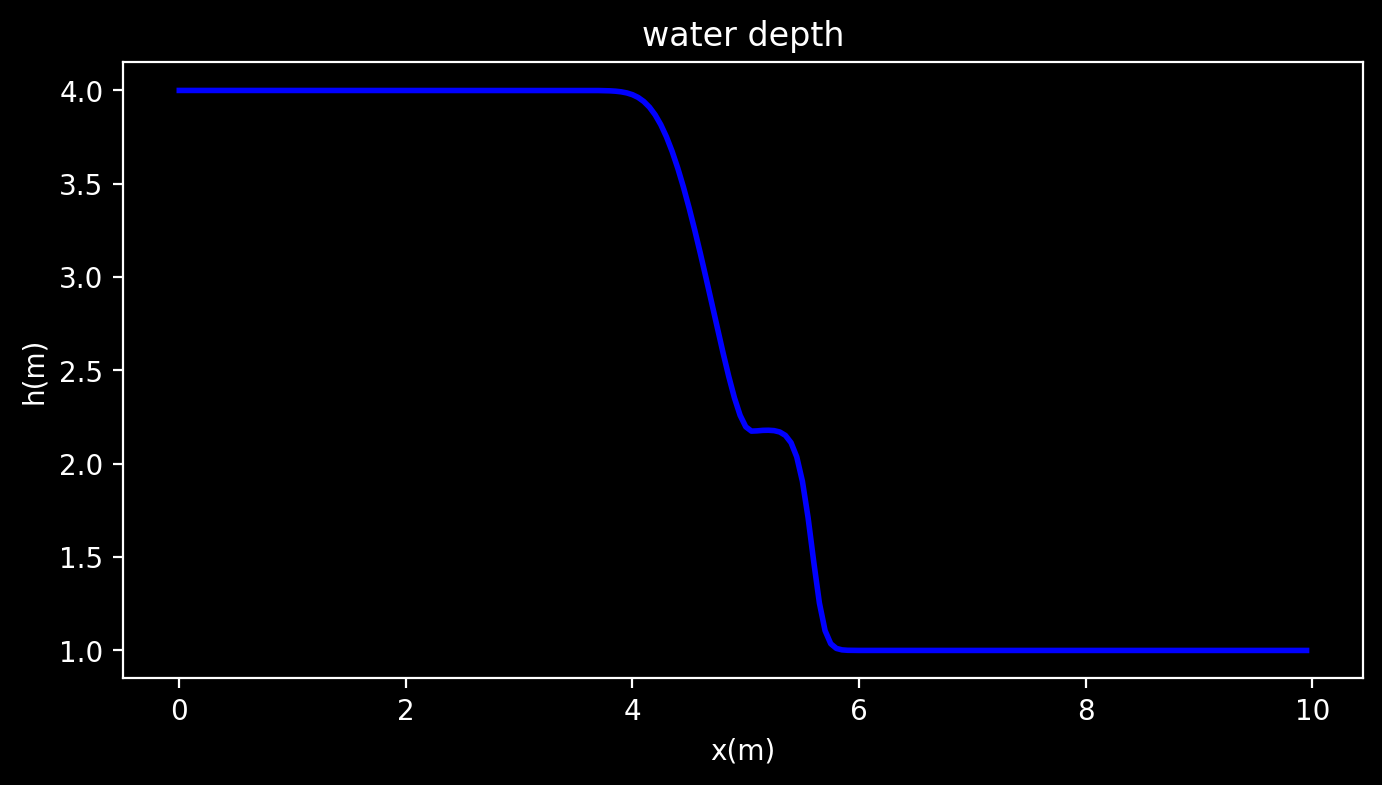

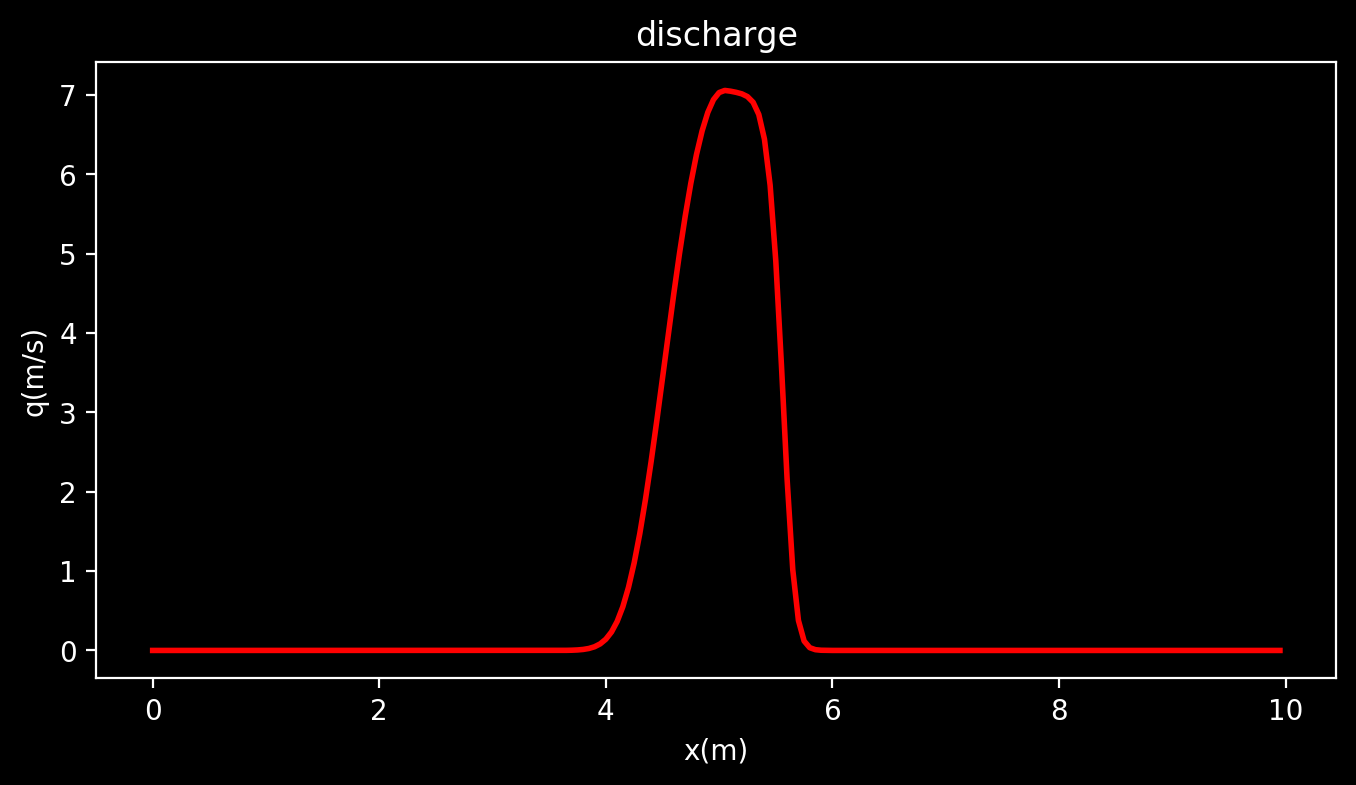

In [6]:
import matplotlib.pyplot as plt
import numpy as np

#data = np.loadtxt('output.txt')

x = np.zeros(200)
for i in range(N):
    x[i] = x_ori + i*dx
    
#h = data[:,1]
#q = data[:,2]
#print(h)
plt.figure(figsize=(8,4))
plt.plot(x,h,color='blue',linewidth=2)
plt.xlabel('x(m)')
plt.ylabel('h(m)')
plt.title('water depth')
#plt.ylim(-0.2,1.2)
plt.show()


plt.figure(figsize=(8,4))
plt.plot(x,q,color='red',linewidth=2)
plt.xlabel('x(m)')
plt.ylabel('q(m/s)')
plt.title('discharge')
#plt.ylim(-0.2,1.2)
plt.show()